In [5]:
import matplotlib.pyplot as plt
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import jax.numpy as jnp
import optax
import jax
import numpy as np
# import ot
# import ot.plot
import ott
from ott.geometry import costs, pointcloud
from ott.problems.linear import linear_problem
from ott.solvers.linear import sinkhorn, solve
import matplotlib.pylab as pl
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,
    IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_linear_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
# from stochastic_interpolant.model_training import train_model

In [6]:
def create_points(rng: jax.Array, n: int, m: int, d: int):
    rngs = jax.random.split(rng, 3)
    x = jax.random.normal(rngs[0], (n, d)) + 1
    y = jax.random.uniform(rngs[1], (m, d))
    return x, y


rng = jax.random.PRNGKey(0)
n, m, d = 13, 17, 2
x, y = create_points(rng, n=n, m=m, d=d)
geom = pointcloud.PointCloud(x, y)

In [8]:
# Define a linear problem with that cost structure.
ot_prob = linear_problem.LinearProblem(geom)
# Create a Sinkhorn solver
# solver = sinkhorn.Sinkhorn()
# Solve OT problem
# ot = solver(ot_prob)
solve_fn = jax.jit(solve)
ot = solve_fn(geom)
# The out object contains many things, among which the regularized OT cost
print(
    " Sinkhorn has converged: ",
    ot.converged,
    "\n",
    "Error upon last iteration: ",
    ot.errors[(ot.errors > -1)][-1],
    "\n",
    "Sinkhorn required ",
    jnp.sum(ot.errors > -1),
    " iterations to converge. \n",
    "Entropy regularized OT cost: ",
    ot.reg_ot_cost,
    "\n",
    "OT cost (without entropy): ",
    jnp.sum(ot.matrix * ot.geom.cost_matrix),
)

 Sinkhorn has converged:  True 
 Error upon last iteration:  0.00068787485 
 Sinkhorn required  6  iterations to converge. 
 Entropy regularized OT cost:  1.4432424 
 OT cost (without entropy):  1.2848572


In [9]:
# Target sample
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)

In [10]:
# Reference Sample
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(num_target,2))

In [11]:
mini_batch_size = 10
data_key = jax.random.PRNGKey(42)
target_key, reference_key = jax.random.split(data_key,2)
target_batch = jax.random.choice(target_key,target_samples,(mini_batch_size,))
reference_batch = jax.random.choice(reference_key,reference_samples,(mini_batch_size,))
a, b = jnp.ones((mini_batch_size,)), jnp.ones((mini_batch_size,))

In [19]:
geom = ott.geometry.pointcloud.PointCloud(reference_batch, target_batch)
prob = ott.problems.linear.linear_problem.LinearProblem(geom)

In [24]:
solver = ott.solvers.linear.sinkhorn.Sinkhorn()
solve_fn = jax.jit(solver)
ot = solve_fn(prob)

In [30]:
ot.matrix@np.ones(mini_batch_size)

Array([0.1000001 , 0.09999991, 0.10000008, 0.10000006, 0.10000004,
       0.10000005, 0.10000015, 0.10000004, 0.10000008, 0.09999999],      dtype=float32)

In [28]:
ot.matrix@target_batch

Array([[ 0.02019827, -0.18028842],
       [ 0.107212  ,  0.03315558],
       [-0.08813947, -0.13440253],
       [ 0.17329088, -0.0345984 ],
       [-0.0094303 , -0.05145795],
       [-0.04815479,  0.04227251],
       [-0.09573606, -0.06484801],
       [-0.1317763 , -0.23629314],
       [ 0.03941869, -0.06808925],
       [-0.05572132, -0.26622912]], dtype=float32)

In [26]:
target_batch

Array([[ 2.0363524 , -0.64102936],
       [-0.3563301 ,  1.2831452 ],
       [ 1.0283146 , -0.46076575],
       [-0.4976885 , -2.7530408 ],
       [-0.5518311 , -2.5823839 ],
       [ 0.8481447 ,  0.70846534],
       [-0.9447352 , -1.4336125 ],
       [-0.05407427, -0.67968106],
       [-1.8540019 , -2.4321947 ],
       [-0.55374384, -0.6205419 ]], dtype=float32)

In [29]:
reference_batch

Array([[ 1.5014935 , -0.70772237],
       [ 2.0352716 ,  0.9590123 ],
       [-0.6655762 ,  0.24713342],
       [ 2.4247074 ,  0.97748315],
       [ 0.22865535,  0.44183236],
       [-1.1129909 ,  0.8109413 ],
       [-1.7719579 ,  0.88920265],
       [-0.70846146, -0.23762281],
       [ 0.64589816,  0.08873966],
       [-0.28726628, -0.86472803]], dtype=float32)

In [239]:
M = ot.dist(reference_batch,target_batch,p=1)

In [240]:
a, b = jnp.ones((mini_batch_size,)), jnp.ones((mini_batch_size,))
G0 = ot.emd(a,b,M)

Text(0.5, 1.0, 'OT matrix with samples')

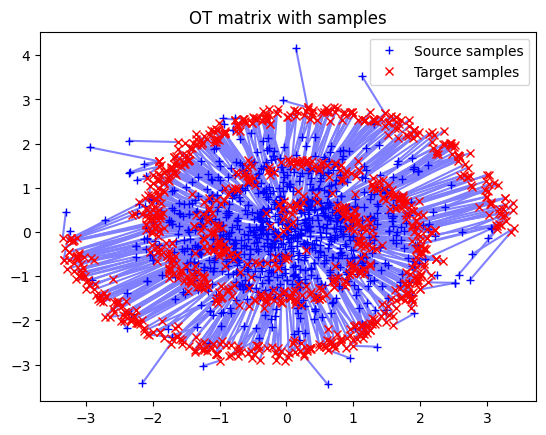

In [241]:
ot.plot.plot2D_samples_mat(np.array(reference_batch), np.array(target_batch), np.array(G0), c=[.5, .5, 1])
pl.plot(reference_batch[:, 0], reference_batch[:, 1], '+b', label='Source samples')
pl.plot(target_batch[:, 0], target_batch[:, 1], 'xr', label='Target samples')
pl.legend(loc=0)
pl.title('OT matrix with samples')

In [242]:
G0@target_batch

Array([[ 3.0132987 ,  0.92995304],
       [ 1.6200284 ,  0.54562664],
       [ 1.1225936 , -0.21110708],
       ...,
       [ 1.4881628 ,  0.73047024],
       [ 0.68160105, -2.5765634 ],
       [ 1.242928  , -2.0505073 ]], dtype=float32)

In [243]:
target_batch

Array([[-0.54242134,  1.5650295 ],
       [ 0.1262104 , -1.3441808 ],
       [ 0.30783322, -2.6868804 ],
       ...,
       [ 1.2974044 ,  0.98629117],
       [-3.1247025 , -0.55394506],
       [-1.6891179 , -0.9456756 ]], dtype=float32)

In [234]:
reference_batch

Array([[ 0.98999083,  0.02760527],
       [-1.7325537 ,  1.5832953 ],
       [-0.5738122 , -0.04246929],
       [ 1.8910633 , -0.46209434],
       [ 2.172503  ,  0.41984123],
       [-0.79204035,  0.91780037],
       [-0.47588974,  1.156665  ],
       [-0.06519935, -0.1658791 ],
       [-1.3465117 , -2.3524277 ],
       [ 0.68188506, -0.57585275]], dtype=float32)